In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sympy
from sympy import *

### Problem setup

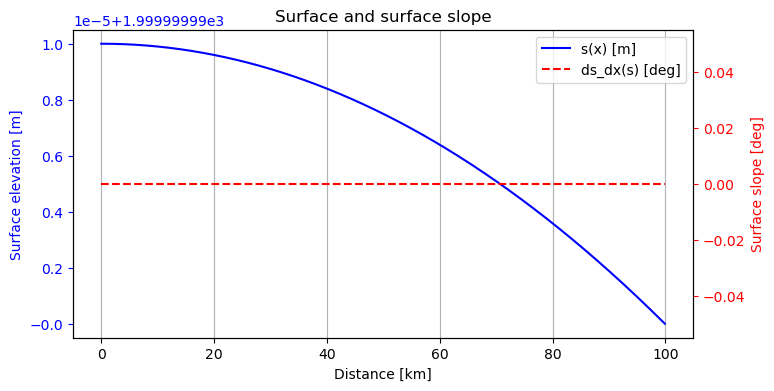

In [311]:
# Domain size
domain_x = 100000 # meters
domain_z = 3000 # meters

# Grids for when discretization is needed
dx = 100
dz = 25
xs = np.arange(0, domain_x, dx)
zs = np.arange(0, domain_z, dz)

# Sympy symbolic variables
x = sympy.symbols('x', real=True, positive=True)
z = sympy.symbols('z', real=True, positive=True)

# Define surface geometry
#surface_sym = domain_z - ((x / 18000.0)**3.0)
surface_sym = 2000 - 1e-5*(x/domain_x)**2
#surface_sym = 2000 - (((x+30000) / 15000.0)**3.0)
#surface_sym = ((domain_z-1600) / (1 + exp(0.00008*(x-(domain_x/2))))) + 1600

surface = sympy.lambdify(x, surface_sym, modules='numpy')


# Use sympy to build a function for the derivative of the surface
ds_dx_sym = sympy.diff(surface_sym, x)

ds_dx = sympy.lambdify(x, ds_dx_sym, modules='numpy')
def ds_dx(x):
    tmp = ds_dx_lambdify(x)
    if np.isscalar(tmp):
        return tmp + (0*x)
    else:
        return tmp

# Plot the surface and its derivative with twin x axes
fig, ax = plt.subplots(figsize=(8, 4))
line_surf = ax.plot(xs/1e3, surface(xs), 'blue', label='s(x) [m]')
ax.tick_params(axis='y', colors='blue')
ax.set_ylabel('Surface elevation [m]', color='blue')
ax_right = ax.twinx()
ax_right.tick_params(axis='y', colors='red')
line_slope = ax_right.plot(xs/1e3, (180/np.pi) * np.tan(ds_dx(xs)), 'r--', label='ds_dx(s) [deg]')
ax_right.set_ylabel('Surface slope [deg]', color='red')

lns = line_surf + line_slope
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper right')

ax.set_title('Surface and surface slope')
ax.set_xlabel('Distance [km]')
ax.grid(True, axis='x')
plt.show()

### Generate SIA-based velocity field

This is a basic SIA velocity field, heavily based on course notes here: https://ocw.hokudai.ac.jp/wp-content/uploads/2016/02/DynamicsOfIce-2005-Note-all.pdf

The input functions (surface(x) and ds/dx(x)) are passed in as symbolic expressions and the outputs are also returned as symbolic expressions.


In [312]:
def sia_model(x_sym, z_sym, surface_sym, dsdx_sym,
              rho=918, g=9.8, A0=3.985e-13, n_A0=3, Q=60e3, R=8.314,
              T_rel_p=(273.15-20), log_ref_stress=6,
              n=3, basal_velocity_sym=0):
    """
    Implementation is based on Section 3.4 of Ralf Greve's course notes:
    https://ocw.hokudai.ac.jp/wp-content/uploads/2016/02/DynamicsOfIce-2005-Note-all.pdf

    Constant defaults and units:
    ρ = 918.0 # kg/m^3
    g = 9.8 # m/s^2
    A0 = 3.985e-13 # s^-1 Pa^-3
    Q = 60.0e3 # J mol^-1
    R = 8.314 # J mol^-1 K^-1
    T_rel_p = 273.15 - 20 # K
    """

    # Baseline case A value
    A = A0 * np.exp(-Q / (R * T_rel_p))

    if n != n_A0:
        log_ref_strain_rate = np.log10(2*A) + n_A0 * log_ref_stress
        log_2A = log_ref_strain_rate - n * log_ref_stress # log10(2*A)
        A = 10**(log_2A) / 2
    
    #print(f"n = {n:.2f}, A = {A:.2e}")

    # Solve for u (horizontal velocity)
    # u_sym = (-2.0 * A * Abs(dsdx_sym)**(n-1.0) * dsdx_sym * rho**n * g**n *
    #          (surface_sym**(n+1.0) - Max(surface_sym - z_sym, 0)**(n+1.0)) / (n + 1.0)) + basal_velocity(x_sym)
    u_sym = (-2.0 * A * Abs(dsdx_sym)**(n-1.0) * dsdx_sym * rho**n * g**n *
             (surface_sym**(n+1.0) - (surface_sym - z_sym)**(n+1.0)) / (n + 1.0)) + basal_velocity_sym
    
    # Recover w (vertical velocity) from u through incompressibility
    du_dx_sym = sympy.diff(u_sym, x_sym)
    dw_dz_sym = -1 * du_dx_sym

    # Integrate up from the bed to find w(x, z)
    # Assume: w(x, z=0) =0 (no basal melt)
    w_sym = sympy.integrate(dw_dz_sym, (z_sym, 0, z_sym))

    return u_sym, w_sym, du_dx_sym


Our SIA model is fully specified by a surface contour (including its derivative) and a basal velocity field. (Plus some constants, but we'll assume those don't change.)

We'd like to generate multiple examples with varying rheology (in this case defined as varying flow exponents) but identical surface velocity fields. In order to do this, we run the SIA model three times:
* First with a "reference n" flow exponent (that must be the lowest value we want to use) and zero basal velocity
* Again with the intended flow exponent and zero basal velocity
* And finally with the intended flow exponent and a basal velocity field calculated to compensate for the difference between the surface velocities of the two prior models.

This means that if we change nothing except for `n` between runs, we get identical surface velocity fields but varying englacial velocities.

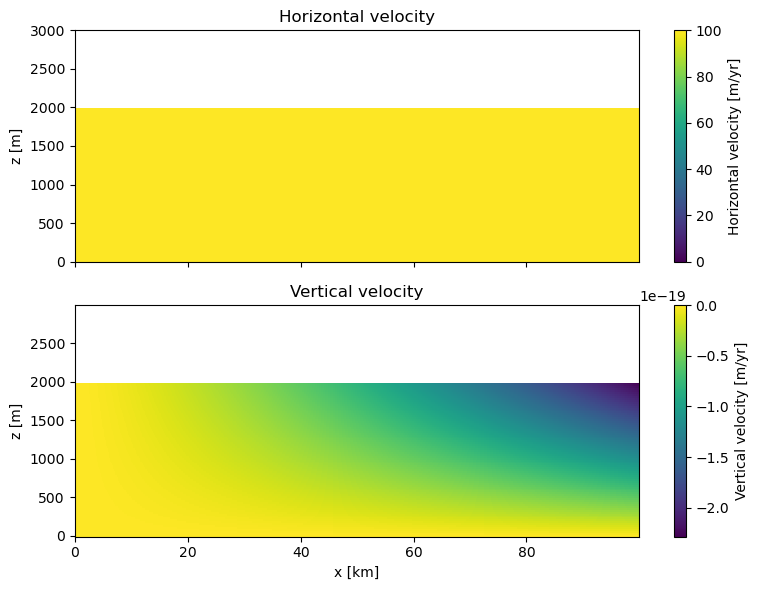

In [337]:
n = 3.0 # Flow exponent for the actual model
reference_n = 2.5 # Flow exponent for the reference model

assert n >= reference_n, ("The reference model flow exponent must be <= n or "
                          "else negative horizontal basal velocities are "
                          "required to make the surface velocities match.")

# Reference run
u_ref, _, _ = sia_model(x, z, surface_sym, ds_dx_sym, n=reference_n)
# Run with intended flow exponent to figure out the needed basal velocity
u_test, _, _ = sia_model(x, z, surface_sym, ds_dx_sym, n=n)
basal_velocity = u_ref.subs(z, surface_sym) - u_test.subs(z, surface_sym) + (100/scipy.constants.year)

# The actual model we'll use going forward
u, w, du_dx = sia_model(x, z, surface_sym, ds_dx_sym, n=n, basal_velocity_sym=basal_velocity)

# Plot the resulting horizontal and vertical velocity fields
X, Z = np.meshgrid(xs, zs)
U = sympy.lambdify((x, z), u, modules='numpy')(X, Z)
W = sympy.lambdify((x, z), w, modules='numpy')(X, Z)

below_surface = (Z < surface(X))
below_surface_mask = np.ones_like(X, dtype=float)
below_surface_mask[~below_surface] = np.nan

fig, (ax_U, ax_dWdz) = plt.subplots(2,1, figsize=(8, 6), sharex=True)
pcm_U = ax_U.pcolormesh(X/1e3, Z, scipy.constants.year*U*below_surface_mask, cmap='viridis', vmin=0)
fig.colorbar(pcm_U, ax=ax_U, label='Horizontal velocity [m/yr]')
ax_U.set_title('Horizontal velocity')
ax_U.set_ylabel('z [m]')
ax_U.set_ylim(0, domain_z)
pcm_W = ax_dWdz.pcolormesh(X/1e3, Z, scipy.constants.year*W*below_surface_mask, cmap='viridis')
fig.colorbar(pcm_W, ax=ax_dWdz, label='Vertical velocity [m/yr]')
ax_dWdz.set_title('Vertical velocity')
ax_dWdz.set_xlabel('x [km]')
ax_dWdz.set_ylabel('z [m]')
fig.tight_layout()
plt.show()

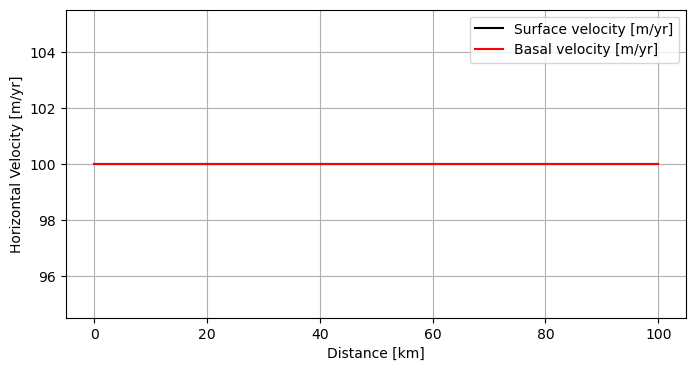

In [338]:
# For verification purposes, also plot the surface velocity

# Calculate the surface velocity (just below the surface to avoid border effects)
u_surface = sympy.lambdify(x, u.subs(z, surface_sym-0.1), modules='numpy')(xs)
u_bed = sympy.lambdify(x, u.subs(z, 0.1), modules='numpy')(xs)

# Plot the surface velocity
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(xs/1e3, scipy.constants.year*u_surface, 'k-', label='Surface velocity [m/yr]')
ax.plot(xs/1e3, scipy.constants.year*u_bed, 'r-', label='Basal velocity [m/yr]')
#ax.set_title('Surface velocity')
ax.legend()
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Horizontal Velocity [m/yr]')
ax.grid(True)
plt.show()

### Generate synthetic layers

In [339]:
def advect_layer(u, w, xs, initial_layer, layer_ages):
    """
    Advect a layer in a vertical velocity field w and horizontal velocity field u.
    The layer is represented as a 1D array of thicknesses at each x position.

    Advection is done by solving an ODE for sampled particles at locations (xs, initial_layer(xs))
    moving through the velocity field (u, w). The ODE is solved for each layer age.

    Args:
    u: Function mapping (x, z) to horizontal velocity at that position
    w: Function mapping (x, z) to vertical velocity at that position
    xs: 1D array of x positions
    initial_layer: A function mapping x positions to the initial layer position
    layer_ages: 1D array of ages of each layer to be output

    Returns:
    An array (of the same length as layer_ages) of functions mapping x positions to the layer position at that age
    """

    zs_initial = initial_layer(xs)-0.1
    # Encode x and y coordinates into flattened list for scipy.integrate.solve_ivp
    y = np.concatenate([xs, zs_initial])

    # Simple 2D advection ODE
    def ode_fun(t, y):
        x = y[:len(y)//2]
        z = y[len(y)//2:]
        dydt = np.concatenate([u(x, z), w(x, z)])
        return dydt
    
    # Integrate the ODE for each layer age
    # Need to do it this way rather than solving for all ages at once because
    # points move too far out of the domain. Re-interpolating them back onto
    # normal x spacing between time steps fixes this.
    t = 0
    advected_layers = []
    for idx, age in enumerate(layer_ages):
        sol = scipy.integrate.solve_ivp(ode_fun, [0, age-t], y, dense_output=True)
        xs_advected = sol.y[:len(y)//2, -1]
        zs_advected = sol.y[len(y)//2:, -1]
        layer_interp = scipy.interpolate.interp1d(xs_advected, zs_advected, fill_value='extrapolate')
        #layer_interp = (lambda x: sol.sol(x)[-1])
        y = np.concatenate([xs, layer_interp(xs)])
        t = age
        advected_layers.append(layer_interp)

    return advected_layers

    # sol = scipy.integrate.solve_ivp(ode_fun, [0, layer_ages[-1]], y_initial, t_eval=layer_ages)
    # print(sol.t.shape)
    # print(sol.y.shape)

    # # Create interpolants for the advected layers
    # advected_layers = []
    # for idx, age in enumerate(layer_ages):
    #     xs_advected = sol.y[:len(y_initial)//2, idx]
    #     zs_advected = sol.y[len(y_initial)//2:, idx]
    #     advected_layers.append(scipy.interpolate.interp1d(xs_advected, zs_advected, fill_value='extrapolate'))
    # return advected_layers

In [378]:
xs_layers = np.linspace(0, domain_x, 100) # don't need tight grid spacing for smooth layers

# As they were made in the Julia script
# layer_ages = np.logspace(0, 4, 20)
# layers_t0 = advect_layer(sympy.lambdify((x, z), u, modules='numpy'),
#                          sympy.lambdify((x, z), w, modules='numpy'),
#                          xs, surface, layer_ages*scipy.constants.year)

# With a little spacing between them
# layer_ages = np.logspace(0, 4, 20)
# layers_t0 = []
# for idx, age in enumerate(layer_ages):
#     start_offset = idx * 100
#     layer_start_fn = lambda x: surface(x) - start_offset
#     layer = advect_layer(sympy.lambdify((x, z), u, modules='numpy'),
#                          sympy.lambdify((x, z), w, modules='numpy'),
#                          xs, layer_start_fn, layer_ages[:idx+1]*scipy.constants.year)
#     layers_t0.append(layer[-1])

# Layer offsets from surface with a short time period of advection
# layers_t0 = []
# for start_offset in np.arange(400, 2300, 200):
#     layer_start_fn = lambda x: surface(x) - start_offset
#     layer = advect_layer(sympy.lambdify((x, z), u, modules='numpy'),
#                          sympy.lambdify((x, z), w, modules='numpy'),
#                          xs_layers, layer_start_fn, [scipy.constants.year * 500])
#     layers_t0.append(layer[-1])

# Manually specified layers
layers_t0 = []
layer_base_fn = lambda x: ((1800-1100) / (1 + np.exp(0.0002*(x-(domain_x/2))))) + 1100
for idx, start_offset in enumerate(np.arange(0, 1000, 150)):
    layer_start_fn = lambda x: (1 - 0.02*idx)*layer_base_fn(x) - start_offset
    layer = advect_layer(sympy.lambdify((x, z), u, modules='numpy'),
                         sympy.lambdify((x, z), w, modules='numpy'),
                         xs_layers, layer_start_fn, [scipy.constants.year * 50])
    layers_t0.append(layer[-1])


Text(0, 0.5, 'z [m]')

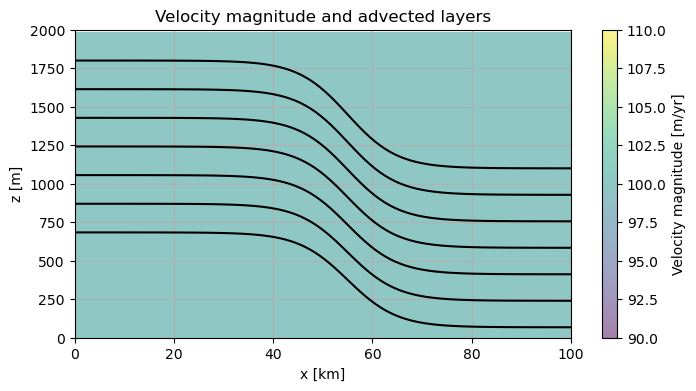

In [379]:
# Plot the advected layers on top of a pcolormesh plot of the velocity magnitude
X, Z = np.meshgrid(xs, zs)
U = sympy.lambdify((x, z), u, modules='numpy')(X, Z)
W = sympy.lambdify((x, z), w, modules='numpy')(X, Z)
vel = np.sqrt(U**2 + W**2)

fig, ax = plt.subplots(figsize=(8, 4))
pcm = ax.pcolormesh(X/1e3, Z, scipy.constants.year * vel * below_surface_mask, cmap='viridis', alpha=0.5)
fig.colorbar(pcm, ax=ax, label='Velocity magnitude [m/yr]')
for layer in layers_t0:
    ax.plot(xs_layers/1e3, layer(xs_layers), 'k-')
# for layer in layers_t1:
#     ax.plot(xs_layers/1e3, layer(xs_layers), 'r--')
ax.set_title('Velocity magnitude and advected layers')
ax.grid(True)
ax.set_xlim(0, domain_x/1e3)
ax.set_ylim(0, surface(0))
ax.set_xlabel('x [km]')
ax.set_ylabel('z [m]')

### Advect layers by 1 year to simulate layer motion

In [380]:
layers_t1 = []
for layer in layers_t0:
    layers_t1.append(advect_layer(sympy.lambdify((x, z), u, modules='numpy'),
                                  sympy.lambdify((x, z), w, modules='numpy'),
                                  xs, layer, [scipy.constants.year * 1])[-1])

### Set up finite difference approximations of layer deformation-related partial derivatives

In [381]:
def layer_dl_dx(x, layer_idx, dx=1):
    """
    Numerical central difference approximation of layer slope
    Output units are m/m
    """
    return (layers_t0[layer_idx](x+(dx/2)) - layers_t0[layer_idx](x-(dx/2))) / dx

def layer_dl_dt(x, layer_idx):
    """
    Numerical forward difference approximation of layer vertical deformation
    Output units are m/year
    """
    return (layers_t1[layer_idx](x) - layers_t0[layer_idx](x))

def layer_d2l_dxdz(x, layer_idx):
    """
    Numerical central difference approximation of d^2l/(dxdz)
    Output units are m/m^2
    """
    layer_p1 = layer_dl_dx(x, layer_idx+1)
    layer_m1 = layer_dl_dx(x, layer_idx-1)
    layer_dz = layers_t0[layer_idx+1](x) - layers_t0[layer_idx-1](x)
    return (layer_p1 - layer_m1) / (layer_dz)

def layer_d2l_dtdz(x, layer_idx):
    """
    Numerical central difference approximtion of d^2l/(dtdz)
    Output units are m/(m*year)
    """
    layer_p1 = layer_dl_dt(x, layer_idx+1)
    layer_m1 = layer_dl_dt(x, layer_idx-1)
    layer_dz = layers_t0[layer_idx+1](x) - layers_t0[layer_idx-1](x)
    return (layer_p1 - layer_m1) / (layer_dz)


Text(0, 0.5, 'z [m]')

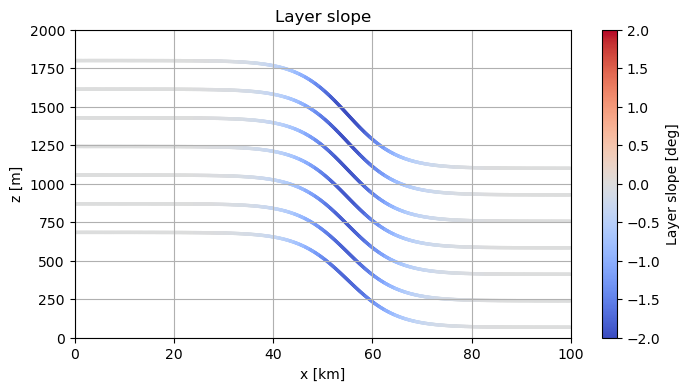

In [382]:
# Plot the advected layers on top of a pcolormesh plot of the velocity magnitude
X, Z = np.meshgrid(xs, zs)
U = sympy.lambdify((x, z), u, modules='numpy')(X, Z)
W = sympy.lambdify((x, z), w, modules='numpy')(X, Z)
vel = np.sqrt(U**2 + W**2)

fig, ax = plt.subplots(figsize=(8, 4))
#pcm = ax.pcolormesh(X/1e3, Z, scipy.constants.year * vel * below_surface_mask, cmap='grey', alpha=0.5)
vmin, vmax = -2, 2
sc = None
for idx, layer in enumerate(layers_t0):
    sc = ax.scatter(xs/1e3, layer(xs), c=np.arctan(layer_dl_dx(xs, idx))*(180/np.pi), s=2, vmin=vmin, vmax=vmax, cmap='coolwarm')
fig.colorbar(sc, ax=ax, label='Layer slope [deg]')
ax.set_title('Layer slope')
ax.grid(True)
ax.set_xlim(0, domain_x/1e3)
ax.set_ylim(0, surface(0))
ax.set_xlabel('x [km]')
ax.set_ylabel('z [m]')

### Method of Characteristics Solution

In [383]:
def du_dtau(tau, u, layer_idx):
    res = -1 * layer_d2l_dxdz(tau, layer_idx)*u - layer_d2l_dtdz(tau, layer_idx)
    #res[np.where(u < 0)] = np.max(res, 0)
    return res

start_pos_x = 100

layer_solutions = {}

for idx in np.arange(1, len(layers_t0)-1):
    layer = layers_t0[idx]
    u0 = u.subs([(x, start_pos_x), (z, layer(start_pos_x))]).evalf() * scipy.constants.year
    layer_solutions[idx] = scipy.integrate.solve_ivp(du_dtau, [start_pos_x, domain_x], np.array([u0]), args=(idx,), dense_output=True, max_step=100)


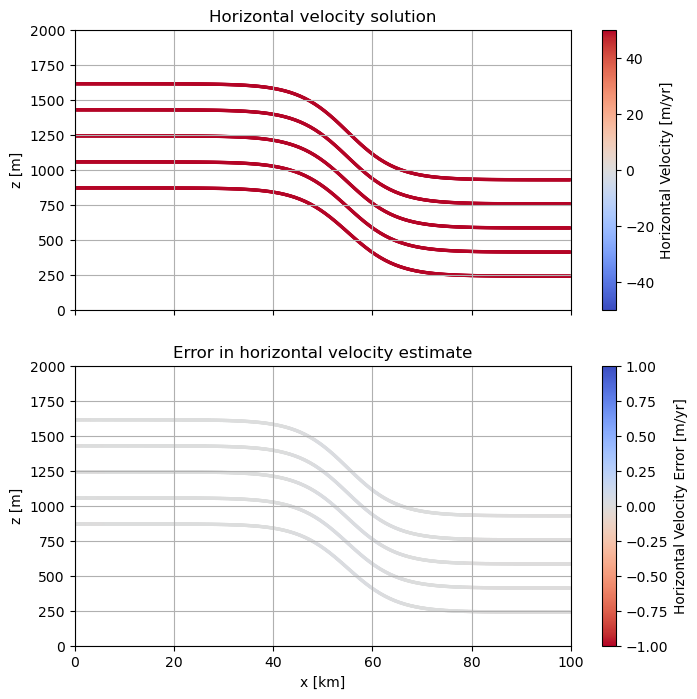

In [384]:
fig, (ax, ax_err) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)
sc = None

# Solution plot
for layer_idx in layer_solutions.keys():
    xs_tmp = xs
    sc = ax.scatter(xs_tmp/1e3, layers_t0[layer_idx](xs_tmp), c=layer_solutions[layer_idx].sol(xs_tmp), vmin=-50, vmax=50, s=2, cmap='coolwarm')
fig.colorbar(sc, ax=ax, label='Horizontal Velocity [m/yr]')

ax.grid(True)
ax.set_xlim(0, domain_x/1e3)
ax.set_ylim(0, surface(0))
#ax.set_xlabel('x [km]')
ax.set_ylabel('z [m]')

# Error plot

for layer_idx in layer_solutions.keys():
    xs_tmp = xs
    err = layer_solutions[layer_idx].sol(xs_tmp) - (sympy.lambdify((x,z), u, modules='numpy')(xs_tmp, layers_t0[layer_idx](xs_tmp)) * scipy.constants.year)
    sc = ax_err.scatter(xs_tmp/1e3, layers_t0[layer_idx](xs_tmp), c=err, vmin=-1, vmax=1, s=2, cmap='coolwarm_r')
fig.colorbar(sc, ax=ax_err, label='Horizontal Velocity Error [m/yr]')

ax_err.grid(True)
ax_err.set_xlabel('x [km]')
ax_err.set_ylabel('z [m]')

ax.set_title('Horizontal velocity solution')
ax_err.set_title('Error in horizontal velocity estimate')
plt.show()

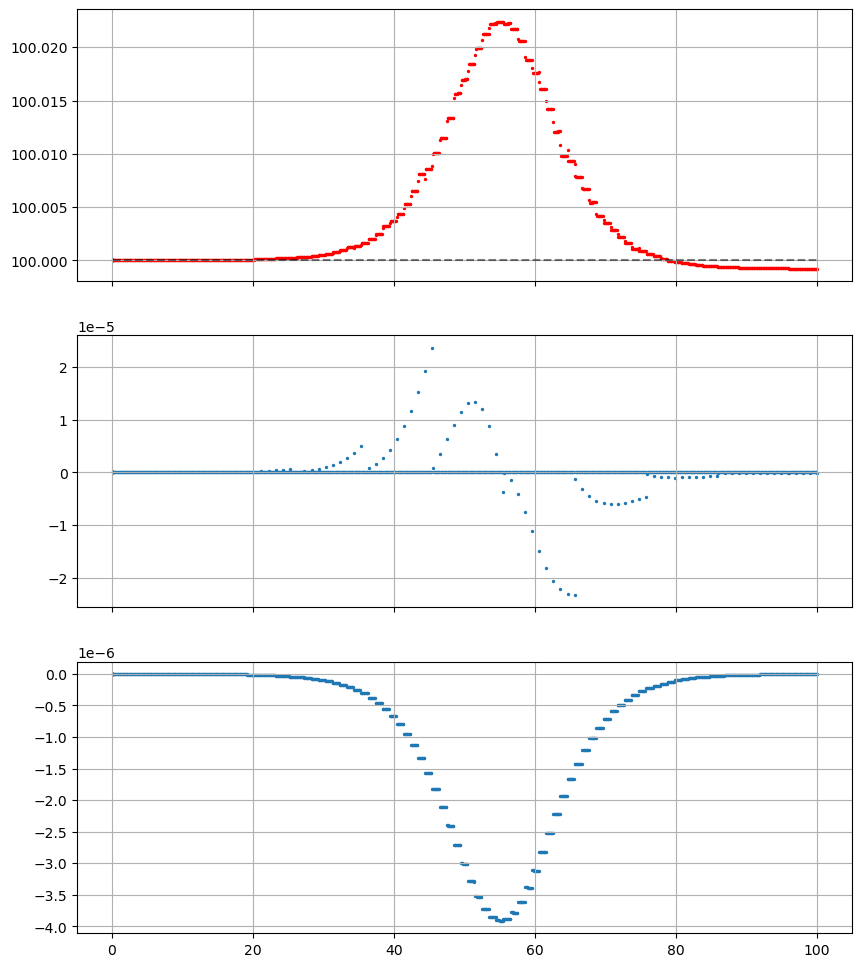

In [385]:
fig, (ax, ax_deriv, ax_stab) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

#for layer_idx in layer_solutions.keys():

layer_idx = 5
sol = layer_solutions[layer_idx]
#ax.plot(xs/1e3, sol.sol(xs)[0,:], 'k--', alpha=0.5)
ax.scatter(sol.t/1e3, sol.y, s=2, label=f'Layer {layer_idx}', c='red')

# True values
xs_tmp = sol.t
ax.plot(xs_tmp/1e3, sympy.lambdify((x,z), u, modules='numpy')(xs_tmp, layers_t0[layer_idx](xs_tmp)) * scipy.constants.year, 'k--', alpha=0.5)

#ax.set_ylim(-20, 20)
ax.grid(True)

# Plot the derivative
xs_tmp = sol.t
ax_deriv.scatter(xs_tmp/1e3, du_dtau(xs_tmp, sol.y[0,:], layer_idx), s=2)
ax_deriv.grid(True)

# Stability criterion

stab_crit = layer_d2l_dxdz(sol.t, layer_idx)
ax_stab.scatter(sol.t/1e3, stab_crit, s=2)
ax_stab.grid(True)

#ax_deriv.set_xlim(start_pos_x/1e3, (start_pos_x/1e3)+1)

plt.show()

### Find vertical velocity from horizontal velocity

In [386]:
# Zero slope approximation vertical strain rate

xs_tmp = xs[xs > start_pos_x]

interp_x = np.zeros((len(layer_solutions), len(xs_tmp)))
interp_z = np.zeros_like(interp_x)
interp_dl_dt = np.zeros_like(interp_x)
for idx, layer_idx in enumerate(layer_solutions.keys()):
    interp_x[idx, :] = xs_tmp
    interp_z[idx, :] = layers_t0[layer_idx](xs_tmp)
    interp_dl_dt[idx, :] = layer_dl_dt(xs_tmp, layer_idx)

X, Z = np.meshgrid(xs_tmp, zs)
dl_dt_zeroslope_grid = scipy.interpolate.griddata((interp_x.flatten(), interp_z.flatten()), interp_dl_dt.flatten(), (X, Z), method='linear')
dw_dz_zeroslope_grid = np.gradient(dl_dt_zeroslope_grid, zs, axis=0)


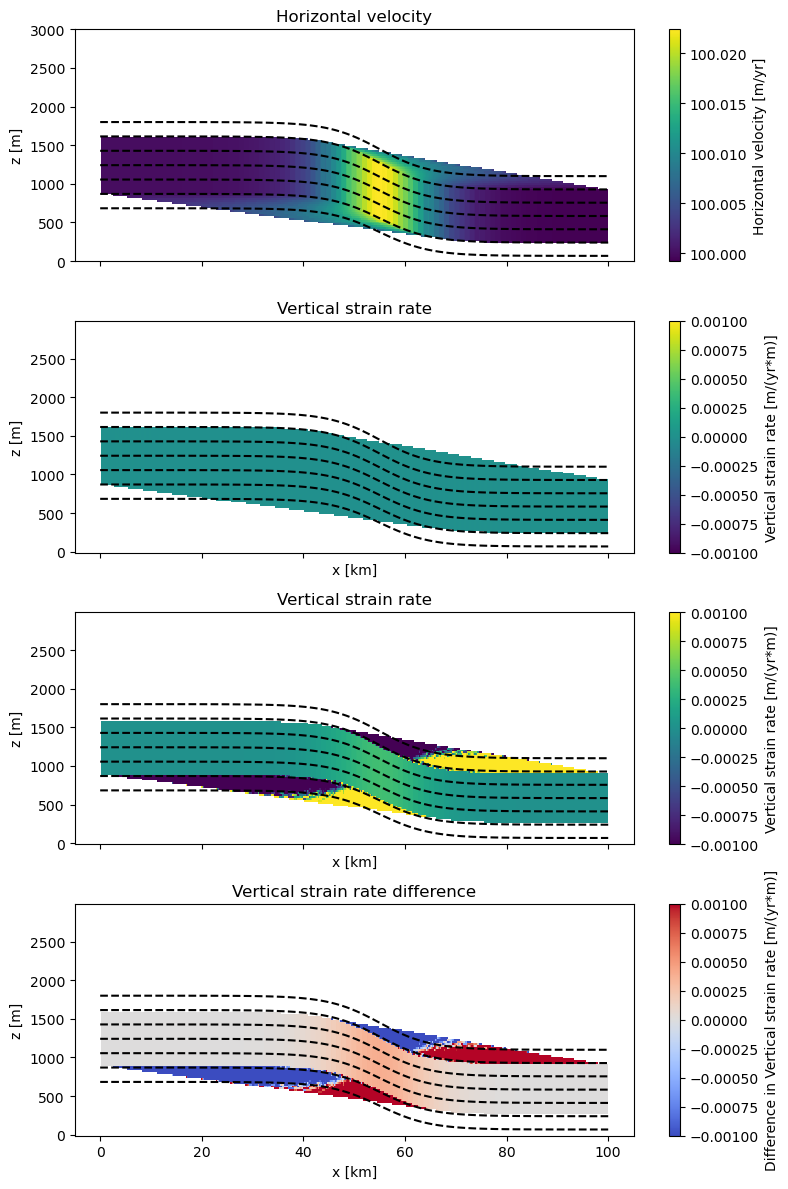

In [389]:
# Interpolate layer solutions to a grid defined by xs and zs
xs_tmp = xs[xs > start_pos_x]
interp_x = np.zeros((len(layer_solutions), len(xs_tmp)))
interp_z = np.zeros_like(interp_x)
interp_u = np.zeros_like(interp_x)
for idx, layer_idx in enumerate(layer_solutions.keys()):
    interp_x[idx, :] = xs_tmp
    interp_z[idx, :] = layers_t0[layer_idx](xs_tmp)
    interp_u[idx, :] = layer_solutions[layer_idx].sol(xs_tmp)[0,:]

# Gridded horizontal velocity from layer line solutions
X, Z = np.meshgrid(xs_tmp, zs)
u_mol_grid = scipy.interpolate.griddata((interp_x.flatten(), interp_z.flatten()),
                                        interp_u.flatten(), (X, Z), method='linear')

# Vertical strain rate
dw_dz_mol_grid = -1 * np.gradient(u_mol_grid, xs_tmp, axis=1)

fig, (ax_U, ax_dWdz, ax_dWdz_zeroslope, ax_dWdz_diff) = plt.subplots(4,1, figsize=(8, 12), sharex=True)
pcm_U = ax_U.pcolormesh(X/1e3, Z, u_mol_grid, cmap='viridis')
fig.colorbar(pcm_U, ax=ax_U, label='Horizontal velocity [m/yr]')
ax_U.set_title('Horizontal velocity')
ax_U.set_ylabel('z [m]')
ax_U.set_ylim(0, domain_z)

vmin, vmax = -0.001, 0.001

pcm_dWdz = ax_dWdz.pcolormesh(X/1e3, Z, dw_dz_mol_grid, cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(pcm_dWdz, ax=ax_dWdz, label='Vertical strain rate [m/(yr*m)]')
ax_dWdz.set_title('Vertical strain rate')
ax_dWdz.set_xlabel('x [km]')
ax_dWdz.set_ylabel('z [m]')

pcm_dWdz_zeroslope = ax_dWdz_zeroslope.pcolormesh(X/1e3, Z, dw_dz_zeroslope_grid, cmap='viridis', vmin=vmin, vmax=vmax)
fig.colorbar(pcm_dWdz_zeroslope, ax=ax_dWdz_zeroslope, label='Vertical strain rate [m/(yr*m)]')
ax_dWdz_zeroslope.set_title('Vertical strain rate')
ax_dWdz_zeroslope.set_xlabel('x [km]')
ax_dWdz_zeroslope.set_ylabel('z [m]')

pcm_dWdz_diff = ax_dWdz_diff.pcolormesh(X/1e3, Z, dw_dz_zeroslope_grid - dw_dz_mol_grid, cmap='coolwarm', vmin=-0.001, vmax=0.001)
fig.colorbar(pcm_dWdz_diff, ax=ax_dWdz_diff, label='Difference in Vertical strain rate [m/(yr*m)]')
ax_dWdz_diff.set_title('Vertical strain rate difference')
ax_dWdz_diff.set_xlabel('x [km]')
ax_dWdz_diff.set_ylabel('z [m]')

for layer in layers_t0:
    ax_U.plot(xs_layers/1e3, layer(xs_layers), 'k--')
    ax_dWdz.plot(xs_layers/1e3, layer(xs_layers), 'k--')
    ax_dWdz_zeroslope.plot(xs_layers/1e3, layer(xs_layers), 'k--')
    ax_dWdz_diff.plot(xs_layers/1e3, layer(xs_layers), 'k--')

fig.tight_layout()
plt.show()